<a href="https://colab.research.google.com/github/sunRise9551/Building_Makemore/blob/main/Makemore_with_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

# Dataset

In [67]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [68]:
len(words)

32033

In [69]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [70]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:

  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
... ---> a
..a ---> v
.av ---> a
ava ---> .
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [71]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [72]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [73]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

# Embedding

## Understand How embedding works

- Create an embedding matrix
- In our case, we have 27 characters in total, and we want to embed into 2 dimensions
- Therefore, we will have a Matrix (27 x 2)


In [74]:
C = torch.randn((27, 2))
C

tensor([[ 0.4112, -1.0683],
        [ 1.4103, -1.0646],
        [-0.8964,  0.5800],
        [ 0.2353,  0.7525],
        [-0.7873,  1.8514],
        [ 0.2359,  0.3113],
        [ 0.1063,  0.0456],
        [ 0.7461,  0.2641],
        [ 0.2186,  1.1205],
        [-1.7456, -1.3379],
        [-0.8673,  1.5946],
        [-0.1189, -0.0655],
        [ 0.7130,  0.3540],
        [ 0.9516,  0.5553],
        [ 1.2834, -0.6690],
        [ 0.3540,  1.0820],
        [-1.5061, -0.7867],
        [ 1.8161, -1.4050],
        [-0.0026,  0.9439],
        [ 0.0158,  0.2572],
        [-1.1775,  0.3911],
        [-1.5979, -1.2809],
        [-0.4660, -0.0138],
        [ 0.8340, -0.6881],
        [-0.6220,  0.2206],
        [-0.5019,  0.1865],
        [-1.1204, -0.1509]])

## How to Embed ?

### Solution 1

Let's say we want to embed integer 5

In [75]:
C[5]

tensor([0.2359, 0.3113])

### Solution 2

Recall from our Makemore_with_Bigram while using One-hot encoding

1. Let's say we want to One-hot encode integer 5 with 27 classes
2. We then multiply by Matrix C

There are identical

In [76]:
F.one_hot(torch.tensor(5), num_classes=27)

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

In [77]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([0.2359, 0.3113])

Integer indexing into lookup table C

As a first layer of the neural net, this layer here has neurons that have no non-linearity, just linear neurons, and their weights matrix is C, and we are encoding integers into One-hot and feeding them to the neural net. And the first layer basically embeds them.

## How to Embed Simultaneously ?

In PyTorch, we can:

In [78]:
C[5]

tensor([0.2359, 0.3113])

In [79]:
C[[5,6,7,8,9,10]]

tensor([[ 0.2359,  0.3113],
        [ 0.1063,  0.0456],
        [ 0.7461,  0.2641],
        [ 0.2186,  1.1205],
        [-1.7456, -1.3379],
        [-0.8673,  1.5946]])

In [80]:
C[[5,6,6,6,6,6,6,7,8,9,10]]

tensor([[ 0.2359,  0.3113],
        [ 0.1063,  0.0456],
        [ 0.1063,  0.0456],
        [ 0.1063,  0.0456],
        [ 0.1063,  0.0456],
        [ 0.1063,  0.0456],
        [ 0.1063,  0.0456],
        [ 0.7461,  0.2641],
        [ 0.2186,  1.1205],
        [-1.7456, -1.3379],
        [-0.8673,  1.5946]])

So, we can simply just do C[X]

In [81]:
emb = C[X]
emb

tensor([[[ 0.4112, -1.0683],
         [ 0.4112, -1.0683],
         [ 0.4112, -1.0683]],

        [[ 0.4112, -1.0683],
         [ 0.4112, -1.0683],
         [ 0.2359,  0.3113]],

        [[ 0.4112, -1.0683],
         [ 0.2359,  0.3113],
         [ 0.9516,  0.5553]],

        [[ 0.2359,  0.3113],
         [ 0.9516,  0.5553],
         [ 0.9516,  0.5553]],

        [[ 0.9516,  0.5553],
         [ 0.9516,  0.5553],
         [ 1.4103, -1.0646]],

        [[ 0.4112, -1.0683],
         [ 0.4112, -1.0683],
         [ 0.4112, -1.0683]],

        [[ 0.4112, -1.0683],
         [ 0.4112, -1.0683],
         [ 0.3540,  1.0820]],

        [[ 0.4112, -1.0683],
         [ 0.3540,  1.0820],
         [ 0.7130,  0.3540]],

        [[ 0.3540,  1.0820],
         [ 0.7130,  0.3540],
         [-1.7456, -1.3379]],

        [[ 0.7130,  0.3540],
         [-1.7456, -1.3379],
         [-0.4660, -0.0138]],

        [[-1.7456, -1.3379],
         [-0.4660, -0.0138],
         [-1.7456, -1.3379]],

        [[-0.4660, -0

In [82]:
emb.shape

torch.Size([32, 3, 2])

### Why is this working ?

Remember our X, is currently the Inputs, that is 32 x 3

32 represents the number

3 represents the correspond character in integer

In [83]:
X.shape

torch.Size([32, 3])

In [84]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

Let's take X[2, 2], gives us integer 13

In [85]:
X[2, 2]

tensor(13)

Let's take C[X] and then we indexing by X[2,2]

We get the embedding.

In [86]:
C[X][2,2]

tensor([0.9516, 0.5553])

Let's verify by indexing C in [13]

In [87]:
C[13]

tensor([0.9516, 0.5553])

Long Story Short, PyTorch Indexing is AWESOME!

# Implement Hidden Layer

## Concept

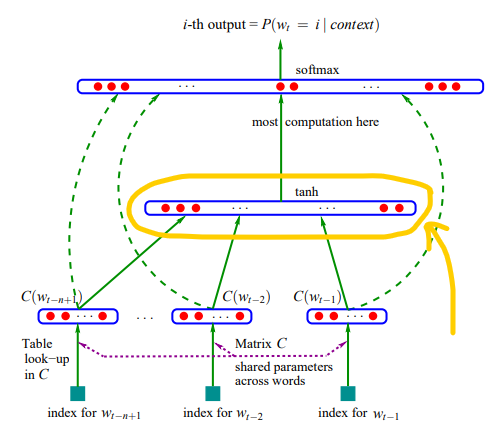

We have our inputs from block (32, 3, 2), we have 3 blocks of this, resulting inputs of 6
  - 32: Characters
  - 3: Input
  - 2: Dimensions
  - Output = Input * Dimensions = 3 * 2 = 6

We have our outputs (Hyperparamter), we choose 100 here.

Let's define our parameters

In [88]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

Normally, we will then multiply them together:

- We cannot do it here, because dimensions doesn't match
- We will need to

In [89]:
emb @ W1 + b1

RuntimeError: ignored

## Solution

In [90]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([32, 6])

This code simply means that we take these 3 blocks, and concatenate them by their 2nd dimension, which is index 1

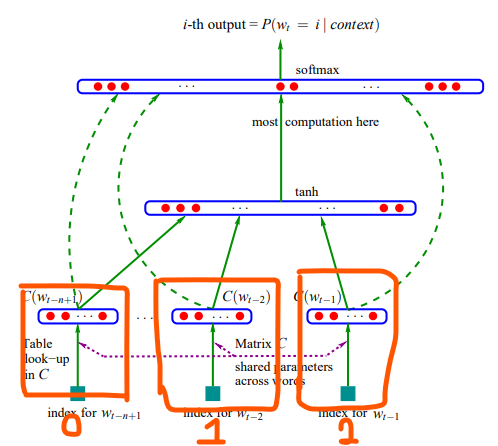

But this is not Generalize, error occurs if our block size changes

## Generalize

We will need to use "unbind"

In [91]:
emb.shape

torch.Size([32, 3, 2])

We unbind the 2nd dimension, which is index 1

In [92]:
torch.unbind(emb, 1)

(tensor([[ 0.4112, -1.0683],
         [ 0.4112, -1.0683],
         [ 0.4112, -1.0683],
         [ 0.2359,  0.3113],
         [ 0.9516,  0.5553],
         [ 0.4112, -1.0683],
         [ 0.4112, -1.0683],
         [ 0.4112, -1.0683],
         [ 0.3540,  1.0820],
         [ 0.7130,  0.3540],
         [-1.7456, -1.3379],
         [-0.4660, -0.0138],
         [ 0.4112, -1.0683],
         [ 0.4112, -1.0683],
         [ 0.4112, -1.0683],
         [ 1.4103, -1.0646],
         [ 0.4112, -1.0683],
         [ 0.4112, -1.0683],
         [ 0.4112, -1.0683],
         [-1.7456, -1.3379],
         [ 0.0158,  0.2572],
         [ 1.4103, -1.0646],
         [-0.8964,  0.5800],
         [ 0.2359,  0.3113],
         [ 0.7130,  0.3540],
         [ 0.4112, -1.0683],
         [ 0.4112, -1.0683],
         [ 0.4112, -1.0683],
         [ 0.0158,  0.2572],
         [ 0.3540,  1.0820],
         [-1.5061, -0.7867],
         [ 0.2186,  1.1205]]),
 tensor([[ 0.4112, -1.0683],
         [ 0.4112, -1.0683],
         [ 0

Both are equivalent:
- torch.unbind(emb, 1)
- [emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]]

Let's concatenate now

In [93]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

## Further Optimize

Because concatenate is waste of storage, further reading

Use "view"

In [94]:
emb.view(32, 6)

tensor([[ 0.4112, -1.0683,  0.4112, -1.0683,  0.4112, -1.0683],
        [ 0.4112, -1.0683,  0.4112, -1.0683,  0.2359,  0.3113],
        [ 0.4112, -1.0683,  0.2359,  0.3113,  0.9516,  0.5553],
        [ 0.2359,  0.3113,  0.9516,  0.5553,  0.9516,  0.5553],
        [ 0.9516,  0.5553,  0.9516,  0.5553,  1.4103, -1.0646],
        [ 0.4112, -1.0683,  0.4112, -1.0683,  0.4112, -1.0683],
        [ 0.4112, -1.0683,  0.4112, -1.0683,  0.3540,  1.0820],
        [ 0.4112, -1.0683,  0.3540,  1.0820,  0.7130,  0.3540],
        [ 0.3540,  1.0820,  0.7130,  0.3540, -1.7456, -1.3379],
        [ 0.7130,  0.3540, -1.7456, -1.3379, -0.4660, -0.0138],
        [-1.7456, -1.3379, -0.4660, -0.0138, -1.7456, -1.3379],
        [-0.4660, -0.0138, -1.7456, -1.3379,  1.4103, -1.0646],
        [ 0.4112, -1.0683,  0.4112, -1.0683,  0.4112, -1.0683],
        [ 0.4112, -1.0683,  0.4112, -1.0683,  1.4103, -1.0646],
        [ 0.4112, -1.0683,  1.4103, -1.0646, -0.4660, -0.0138],
        [ 1.4103, -1.0646, -0.4660, -0.0

Verify

In [95]:
emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

Back to our concept of multiplying

In [96]:
# emb @ W1 + b1
h = emb.view(32, 6) @ W1 + b1

Add a Tanh

In [97]:
h = torch.tanh(emb.view(32, 6) @ W1 + b1)

To not Hard code the block

In [98]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape

torch.Size([32, 100])

# Implement SoftMax

In [99]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [100]:
logits = h @ W2 + b2

In [101]:
logits.shape

torch.Size([32, 27])

## Loss

In [104]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([32, 27])

In [105]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(14.5687)

# Quick Summary

## F.cross_entropy

In [106]:
# ------------ now made respectable :) ---------------

In [107]:
X.shape, Y.shape # dataset

(torch.Size([32, 3]), torch.Size([32]))

In [109]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [110]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [111]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
# ---------------------------------------------
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims=True)
# prob.shape
# --------------------------------------------- To unefficient, we will not use this typically
loss = F.cross_entropy(logits, Y)
loss

tensor(17.7697)

## Why cross_entropy?

Reason 1: Forward pass is much more efficient

Reason 2: Backward pass is much more efficient

Reason 3: Things can be much more numerical much behave (exponential case)

In [112]:
# Exercises Prove these

# Train

In [113]:
# Set requires_grad to True
for p in parameters:
  p.requires_grad = True

In [115]:
for i in range(100):

  # forward pass
  emb = C[X] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y)
  print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  for p in parameters:
    p.data += -0.1 * p.grad

0.25360995531082153
0.253610759973526
0.25360769033432007
0.2536084055900574
0.25360536575317383
0.25360608100891113
0.2536030411720276
0.2536037862300873
0.25360071659088135
0.2536014914512634
0.2535983622074127
0.2535991668701172
0.25359606742858887
0.25359678268432617
0.2535938024520874
0.2535945177078247
0.2535914480686188
0.25359222292900085
0.2535891532897949
0.253589928150177
0.25358685851097107
0.25358766317367554
0.2535845935344696
0.2535853385925293
0.2535823583602905
0.25358307361602783
0.25358009338378906
0.253580778837204
0.2535777986049652
0.2535785436630249
0.25357556343078613
0.25357627868652344
0.25357329845428467
0.253574013710022
0.2535710632801056
0.2535717487335205
0.2535687983036041
0.2535695433616638
0.25356656312942505
0.25356727838516235
0.25356432795524597
0.2535650134086609
0.2535620629787445
0.2535628080368042
0.2535598874092102
0.2535606026649475
0.25355765223503113
0.25355833768844604
0.25355544686317444
0.25355613231658936
0.253553181886673
0.253553926944

## Something Weird

Our loss stuck at 0.25, this is because due to our dataset, we are not able to completely overfit

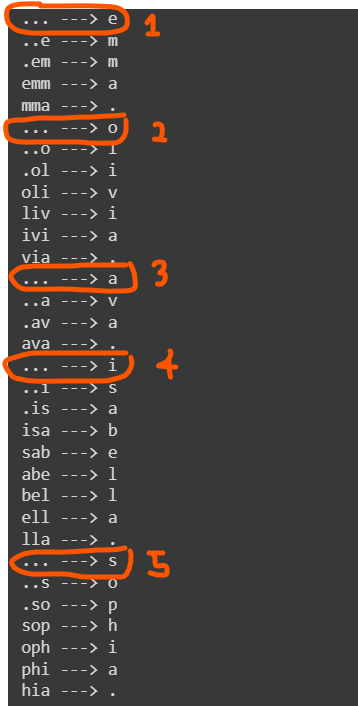

What we need to know is just that its normal if our loss can never go down until a point.

## Batch Problem

Let's load all of our names as Dataset

In [119]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words: # <------------ Loading all names

  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [120]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [121]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [122]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [123]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
# ---------------------------------------------
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims=True)
# prob.shape
# --------------------------------------------- To unefficient, we will not use this typically
loss = F.cross_entropy(logits, Y)
loss

tensor(19.5052)

Train

In [124]:
# Set requires_grad to True
for p in parameters:
  p.requires_grad = True

If you run the below code, you will see that the training is slow, because we haven't batch them.

In [125]:
for i in range(100):

  # forward pass
  emb = C[X] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y)
  print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  for p in parameters:
    p.data += -0.1 * p.grad

19.505226135253906
17.08449363708496
15.776531219482422
14.833340644836426
14.002603530883789
13.253260612487793
12.57991886138916
11.983101844787598
11.47049331665039
11.051856994628906
10.709586143493652
10.407632827758789
10.127808570861816
9.864365577697754
9.61450481414795
9.376440048217773
9.148944854736328
8.931111335754395
8.722230911254883
8.521749496459961
8.329227447509766
8.144326210021973
7.966792106628418
7.796451091766357
7.633185863494873
7.476908206939697
7.327521800994873
7.1848859786987305
7.048791885375977
6.918952465057373
6.795018196105957
6.6766037940979
6.563317775726318
6.454789161682129
6.350668907165527
6.250643253326416
6.1544318199157715
6.061785697937012
5.972482204437256
5.886328220367432
5.803146839141846
5.722784519195557
5.645094394683838
5.5699462890625
5.497213363647461
5.4267802238464355
5.3585357666015625
5.2923760414123535
5.228203773498535
5.165928363800049
5.105468273162842
5.046748161315918
4.98969841003418
4.934261322021484
4.880379676818848
4

## Batch Solution

In [126]:
# torch.randint(0, 5, (32,))
# Generate number from 0 to 5, total counts 32

torch.randint(0, X.shape[0], (32,))

tensor([227531,  52358,  60257,  43121, 184925, 191370, 203600, 182109, 182073,
        179385, 226779, 219725,  46755, 150242, 100309,  17162, 215153, 208577,
        210048, 179421,  81168, 186188, 205610,  15037,  77358,   1596,  66873,
        176715,  69932, 122499,  49358, 164346])

Implement Batch while Training

In [127]:
for i in range(100):
  ix = torch.randint(0, X.shape[0], (32,))

  # forward pass
  emb = C[X[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y[ix])
  print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  for p in parameters:
    p.data += -0.1 * p.grad

3.5509066581726074
3.869478702545166
3.5586676597595215
3.5341084003448486
2.899401903152466
4.367391586303711
2.634936571121216
3.6948227882385254
4.003003120422363
3.8328652381896973
3.641920566558838
3.394965648651123
3.0541393756866455
3.6658856868743896
3.7613956928253174
3.994630813598633
4.195417881011963
4.278409481048584
3.7814524173736572
3.215852975845337
4.106485843658447
2.9105050563812256
3.4624557495117188
3.0041086673736572
3.4655497074127197
3.129237174987793
4.088265895843506
3.1091506481170654
4.028305530548096
2.9234416484832764
3.5332205295562744
3.3787660598754883
3.920553684234619
3.476867198944092
3.0350403785705566
3.3098416328430176
4.0733232498168945
3.519693613052368
3.1285171508789062
3.067735433578491
3.0917301177978516
3.8729326725006104
3.5887956619262695
3.130911350250244
2.5745084285736084
3.5350496768951416
2.530874729156494
2.8943891525268555
3.3730626106262207
3.8967580795288086
3.239254951477051
2.675168752670288
3.1426708698272705
3.25988507270813

# Mini-Batch Loss vs No-Batch Loss

bla bla bla, exercises, why

## Mini-Batch Loss

In [132]:
for i in range(100):
  ix = torch.randint(0, X.shape[0], (32,))

  # forward pass
  emb = C[X[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y[ix])
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  for p in parameters:
    p.data += -0.1 * p.grad

print(loss.item())

2.754147529602051


## No-Batch Loss

In [133]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
loss

tensor(2.7646, grad_fn=<NllLossBackward0>)

# Finding a good Loss function

## Solution 1

In [151]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [152]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [153]:
# Set requires_grad to True
for p in parameters:
  p.requires_grad = True

In [154]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [155]:
lri = []
lossi = []

In [156]:
for i in range(1000):

  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32,))

  # forward pass
  emb = C[X[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Y[ix])
  print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = lrs[i]
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  lri.append(lr)
  lossi.append(loss.item())

#print(loss.item())

18.136716842651367
20.428335189819336
17.732776641845703
19.362628936767578
19.29833984375
17.82460594177246
17.308635711669922
19.08736228942871
17.227214813232422
20.117849349975586
17.72260284423828
20.10552215576172
21.96315574645996
16.993553161621094
20.179590225219727
19.283281326293945
21.369356155395508
19.974328994750977
18.492216110229492
19.062213897705078
18.87863540649414
20.597976684570312
17.7109317779541
18.386932373046875
18.048307418823242
18.823734283447266
17.48239517211914
23.28224754333496
17.765615463256836
13.433892250061035
18.70766258239746
18.89609146118164
19.673688888549805
15.739903450012207
17.768260955810547
18.523054122924805
21.22907257080078
17.818002700805664
17.41848373413086
19.93790626525879
17.10490608215332
18.9587345123291
20.773723602294922
20.434368133544922
21.113039016723633
17.988643646240234
18.086660385131836
18.51531982421875
19.306074142456055
19.58075714111328
21.788448333740234
20.393388748168945
18.521808624267578
20.04612922668457

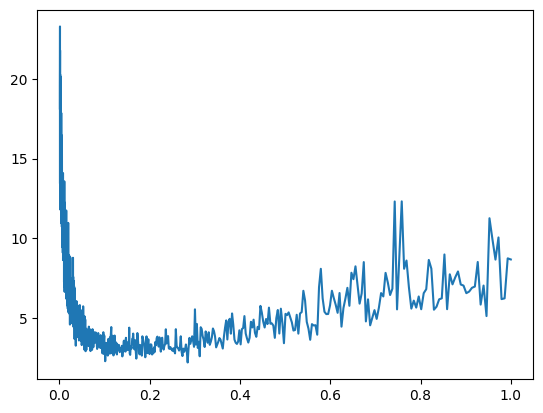

In [157]:
plt.plot(lri, lossi)